# `III. Multipole Expansion` 
This .pynb file reads `./inter_results/field_result.pkl` generated by `./II_Field_Simulation.ipynb`, and analyzes the field distribution result. This analysis can be specific according to your own need. Here, as an example, we focus on multipole expansion coefficient. 

## (1) import electric field and set parameters for it.

In [1]:
import sys
sys.path.append('../../')
import scipy.ndimage as im
import pickle
# add multipoles package path
import pandas as pd
from utils.multipoles import MultipoleControl
from utils.plottingfuncns import *

from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
import os
import matplotlib.cm as cm
from collections import OrderedDict
module_path = os.path.abspath('')
from utils.helper_functions import *

## Import Simulated Data

In [2]:
###### loading in pickle file ###############################
# import data, and define parameters
module_path = os.path.abspath('')

radius= 500e-3
area = 1e-4

path = module_path+'/inter_results/htrap_cutout/htrap_cutout_el2_'+str(radius)+'_'+str(area)+'_simulation.pkl'
# el2
zl = -450*1e-3
# el3.5
# zl = -210*1e-3
# el4
# zl = -100*1e-3

#other simulations
########################################################################################################################
# path = module_path+'/inter_results/htrap_cutout/charge_mit_charge_0.1_5e-06_simulation.pkl'
# path = module_path+'/inter_results/htrap_cutout/simple_roughness_1.0_2e-06_simulation.pkl'
# file_out = 'htrap_cutout_overhang_taper_el3'
# path = module_path+'/inter_results/taper_overhang/'+file_out+'_'+str(radius)+'_'+str(area)+'_simulation_tall_rough.pkl'
########################################################################################################################


print(str(area))
# file_out = 'htrap_cutout_el4'
# path = module_path+'/inter_results/htrap_cutout/'+file_out+'_'+str(radius)+'_'+str(area)+'_simulation.pkl'


f = open(path, 'rb')
trap = pickle.load(f)
# trap['X'], trap['Y'], trap['Z'] are the position coordinates for the simulated volume
print("x positions of the simulation")
print(trap['Z'])
#trap['electrodes'] is a dictionary with keys that correspond to each electrode
print("electrodes simulated")
print(trap['electrodes'].keys())
#plugging in one of the keys, in this case 'DC1,' gives access to the 3-dimensional 
#simulated potentials for that electrode while 'position' is just a refeerence location
# for easy plotting using matplotlib that can be set anytime.  
print("shape of the simulated potential voltages for DC1")
# print(np.shape(trap['electrodes']['DC1']['potential']))
# print(trap['electrodes']['DC1']['position'])
#the 'potential' for 'RF' is really the |E|^2, which can be used to generate the pseudopotential
#note that the units are V/mm^2- all the units in these files are mm b/c that's what fusion360 exports,
#that coordinate system is continued just for consistency. 
print("shape of the simulated |E|^2 for RF")
print(np.shape(trap['electrodes']['RF']['potential']))

#############################################################

0.0001
x positions of the simulation
[-0.455 -0.454 -0.453 -0.452 -0.451 -0.45  -0.449 -0.448 -0.447 -0.446
 -0.445]
electrodes simulated
dict_keys(['DC1', 'DC2', 'DC3', 'DC4', 'DC5', 'DC6', 'DC7', 'DC8', 'DC9', 'DC10', 'DC11', 'DC12', 'DC13', 'DC14', 'DC15', 'DC16', 'DC17', 'DC18', 'DC19', 'DC20', 'DC21', 'RF'])
shape of the simulated potential voltages for DC1
shape of the simulated |E|^2 for RF
(11, 11, 11)


In [3]:

###### setting up multipole expansion @ trap location #######
#xl, yl, zl define the origin at which we will do the multipole expansion
#i.e. they define where you want to trap

#strs are the string names of your DC electrodes (copy from loading pickle,
#I wrote it a second time so that the code runs in case you comment out that code)

strs = list(trap['electrodes'].keys())
xl = 3.75*1e-3
yl = 75*1e-3

position = [xl, yl, zl]

#ROI = 'range of interest', I believe
#It defines the volume region over which multipole expansion will be performed.
#nROI is the number of points that make up the dimensions of the volume of the ROI
#I believe it ends up being the indices of the 3-d array that you index so it is dimensionless
nROI = 2
roi = [nROI, nROI, nROI]
order = 2

#controlled electrodes- this will define which electrodes will be used to control your trap
controlled_electrodes = []

## (2) set parameters for multipole expansion
notes:
* new from shuqi's code- 'excl' defines a dictionary of excluded electrodes the dictionary index (left of colon)  is the electrode you want to exclude its value (right of colon) defines what you want to set it to if you set it to "gnd" it will always set the voltage of that DC to 0 if you set it to "DCx" it will always set the voltage of that DC to be the same as DCx this is in case you have trap shorts, if you don't need it just don't include the indices

In [4]:
# excl = {
#     "DC9":"gnd",
#     "DC11":"gnd",
#     "RF":"gnd",
#     "DC0":"gnd"
#     "DC2":"DC3"

# }

# RF should be set to ground to do a multipole decomposition of the DC fields. 
# Setting RF to ground means that no DC bias is applied to the RF. 
excl = {"RF":"gnd"}

#build the controlled electrodes list, given the constraints of the 'excl' list
for electrode in strs:
    if electrode in excl and excl[electrode] != "gnd":
        trap['electrodes'][excl[electrode]]["potential"] = trap['electrodes'][excl[electrode]]["potential"] + \
                                                           trap['electrodes'][electrode]["potential"]
    elif electrode not in excl:
        controlled_electrodes.append(electrode)

#which multipoles you want to include in multipole calculations
used_order1multipoles = ['Ex', 'Ey', 'Ez']
used_order2multipoles = ['U1', 'U2', 'U3','U4','U5']
used_multipoles = used_order1multipoles + used_order2multipoles
print(np.shape(trap['electrodes'][electrode]["potential"]))

# create MultipoleControl object
s = MultipoleControl(trap, position, roi, controlled_electrodes, used_multipoles, order)
s.electrode_positions = OrderedDict([('DC1', [0, 1]), ('DC2', [0, 2]), ('DC3', [0, 3]), ('DC4', [0, 4]), 
             ('DC5', [0, 5]), ('DC6', [0, 6]), ('DC7', [0, 7]), ('DC8', [0, 8]), 
             ('DC9', [0, 9]), ('DC10', [0, 10]), ('DC11', [2, 1]), ('DC12', [2, 2]), 
             ('DC13', [2, 3]), ('DC14', [2, 4]), ('DC15', [2, 5]),('DC16', [2, 6]),
             ('DC17', [2, 7]),('DC18', [2, 8]),('DC19', [2, 9]),('DC20', [2, 10]),
             ('DC21', [1, 1]),('RF', [1, 2])])
print(controlled_electrodes)

#     return s
# s,used_multipoles = generate_s(excl)
###############################################################

(11, 11, 11)
['DC1', 'DC2', 'DC3', 'DC4', 'DC5', 'DC6', 'DC7', 'DC8', 'DC9', 'DC10', 'DC11', 'DC12', 'DC13', 'DC14', 'DC15', 'DC16', 'DC17', 'DC18', 'DC19', 'DC20', 'DC21']


## Plotting RF Fields
This shows a contourplot of the RF pseudopoential field, as well as the RF null. 
There is also a section to find the saddle point so that the trap depth can be found. A the simulation volume needs to capture the saddle point for this to work. 

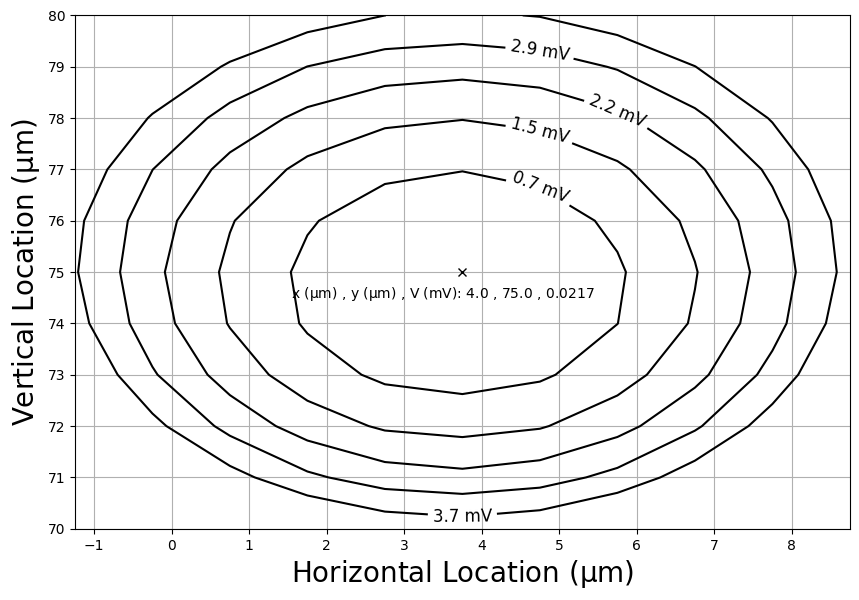

In [5]:
# Generating pseudopotential
##############################################################################################################################
#q = ion charge
#l = units of used to specify simulation grid, should likely be 1 mm
#Omega = trap drive angular frequency
#voltage = RF voltage
#v_to_mV = convert pseudopotential units from volts to millivolts
q = 1.6*1e-19
l = 1e-3
m = 40*1.66054e-27
Omega = 2*np.pi*39.15*1e6
voltage = 80
v_to_mV = 1000 
# voltage = 50*1.26 for taper trap based on lower radial x  (2.08MHz @ 1.5dbm R&S, ~1.4 W transmitted power)

#generating pseudopotential from simulated |E|^2 of RF field
d = trap['electrodes']['RF']['potential'][:,:,0]*voltage**2*q/(4*m*Omega**2)/l**2*v_to_mV
##############################################################################################################################

# taper trap stuff
##############################################################################################################################
# for taper trap: u2 solution that can be superimposed onto the RF
# u2_soln =\
# [0.322124,0.245919,-2.669645,0.243209,-0.296533,-0.256699,-0.212897,-0.172587,
# -0.136261,-0.111947,-0.260888,-0.391296,-2.656598,-0.378270,-0.208301,-0.181067
# ,-0.149683,-0.115415,-0.089443,-0.072666,-0.374573]
# pot_array = np.zeros(np.shape(trap['electrodes']['RF']['potential'][:,:,0]))
# for i in np.arange(1,21,1):
#     pot_array = pot_array+trap['electrodes']['DC'+str(i)]['potential'][:,:,0]*u2_soln[i]*20
# d = d+pot_array
##############################################################################################################################

# Generate contour plot
##############################################################################################################################
#generate figure to plot RF fields
plt.figure(figsize=(30/3,20/3))

#numInter = number of points used to interpolate between points
#CAUTION: no idea what the interpolation function looks like, so be wary of using the 
# interpolated for quantitative calculations or multipoe decomposition. I only use it
# so I can smooth out out the field to get a basic idea of what the RF looks like when 
# I'm not using many gridpoints in the simulation
# num_inter = 5
# d = im.zoom(d, num_inter)
# x = im.zoom(trap['X'],num_inter)*1e3
# y = im.zoom(trap['Y'],num_inter)*1e3


#d is RF pseudopotential field 
#x , y are the x, y axes
d = d
x = trap['X']*1e3
y = trap['Y']*1e3


#setting contour values
min_val = np.min(d)
max_val =  np.max(d)*0.5
steps = 5
c_range = np.arange(min_val,max_val,(max_val-min_val)/(steps+1))

#plotting contours
cmap = LinearSegmentedColormap.from_list('black', ['black', 'black'])
CS = plt.contour(x,y,np.transpose(d),levels=c_range,cmap=cmap,zorder=2)

#labeling contours
def fmt(x):
    s = f"{x:.1f}"
    if s.endswith("0"):
        s = f"{x:.0f}"
    return rf"{s} mV" if plt.rcParams["text.usetex"] else f"{s} mV"
plt.clabel(CS, CS.levels, inline=True,fmt=fmt,fontsize=12,use_clabeltext=True)
##############################################################################################################################


# Find location of the RF null
##############################################################################################################################
min_value = np.min(d[:,:])
coordinates = np.where(d == min_value)
plt.plot(x[coordinates[0][0]],y[coordinates[1][0]],'kx')
min_x = np.round(x[coordinates[0]],0)[0]
min_y = np.round(y[coordinates[1]],0)[0]
plt.text(min_x-0.5,min_y-0.5,
         r"x ($\mathrm{\mu m}$) , y ($\mathrm{\mu m}$) , V (mV): "
         +str(min_x)+' , '+str(min_y)+' , '+str(np.round(d[coordinates[0][0],coordinates[1][0]],4)),color='k',
         horizontalalignment='center')
# plt.text(xval-10,yval-20,
#          r"(x ($\mathrm{\mu m}$),y ($\mathrm{\mu m}$),V (mV)): ("
#          +str(min_x)+','+str()+','+str(np.round(d[coordinates[0][0],coordinates[1][0]],4))+')',color='b')
##############################################################################################################################


# Saddle Finding (only works if simulation goes to 150-160um away from the trap)
##############################################################################################################################
# def find_saddle(V,X,Y):
#     """Returns the indices of the local extremum or saddle point of the scalar A as (Is,Js,Ks).
#     V is a 3D matrix containing an electric potential and must solve Laplace's equation
#     X,Y,Z are the vectors that define the grid in three directions
#     Z0: Z coordinate for saddle finding in a 2D potential slice
#     For dim==2, the values of A are linearly extrapolated from [Z0] and [Z0]+1
#     to those corresponding to Z0 and Ks is such that z[Ks]<Z0, z[Ks+1]>=Z0."""
#     V2=V
#     if len(V.shape)==3:
#         Ks=0 # in case there is no saddle point
#         for i in range(len(Z)):
#             if Z[i-1]<Z0 and Z[i]>=Z0:
#                 Ks=i-1
#                 if Z0<1:
#                     Ks+=1
#         Vs=V.shape
#         if Ks>=len(Z):
#             return('The selected coordinate is at the end of range.')
#         v1=V[:,:,Ks]
#         v2=V[:,:,Ks+1]
#         V2=v1+(v2-v1)*(Z0-Z[Ks])/(Z[Ks+1]-Z[Ks])
#     V2s=V2.shape
#     if len(V2s)!=2: # Old: What is this supposed to check? Matlab code: (size(size(A2),2) ~= 2)
#         return('Problem with find_saddle.py dimensionalities. It is {}.'.format(V2s))
#     f=V2/float(np.max(abs(V2)))
#     [Ex,Ey]=np.gradient(f,abs(X[1]-X[0]),abs(Y[1]-Y[0]))
#     E=np.sqrt(Ex**2+Ey**2)
#     m=float(np.min(E))
#     mr=E[0,0]
#     Is,Js=1,1 # in case there is no saddle
#     for i in range(E.shape[0]):
#         for j in range(E.shape[1]):
#             if E[i,j]<mr:
#                 mr=E[i,j]
#                 Is,Js=i,j
#     origin=[Is,Js]
#     if Is==1 or Is==V.shape[0]:
#         print('find_saddle: Saddle out of bounds in  x (i) direction.\n')
#         return origin
#     if Js==1 or Js==V.shape[1]:
#         print('find_saddle: Saddle out of bounds in  y (j) direction.\n')
#         return origin
#     return origin
# [x_index_saddle,y_index_saddle]=find_saddle(d,x,y)
# z = im.zoom(trap['Z'],numInter)
# plt.plot(x[x_index_saddle],y[y_index_saddle],'kx')
# xval = np.round(x[x_index_saddle])
# yval = np.round(y[y_index_saddle])
# plt.text(x[x_index_saddle]-25,y[y_index_saddle]-5,
#          r"(x ($\mathrm{\mu m}$),y ($\mathrm{\mu m}$),V (mV)): ("+
#          str(xval)+','+str(yval)+','+str(np.round(d[x_index_saddle,y_index_saddle],1))+')'
#          ,color='k',fontsize=7)
# plt.plot([6,45],[70,35],color='k',linestyle=':')
##############################################################################################################################


# plot taper trap elecrodes
##############################################################################################################################

# x = [18,33,33,23,23,-23,-23,-33,-33,-18]
# y = [0,-15,-20,-20,-50,-50,-20,-20,-15,0]
# plt.fill(x, y,zorder=2,facecolor='blue',edgecolor='k')
# x = [-33,-33,-18,18,33,33]
# y = [-20,-15,0,0,-15,-20]
# plt.plot(x, y,zorder=2,color='red',lw=4)

# x = [-68,-53,-53,-63,-63,-123,-123,-133,-133,-118]
# y = [0,-15,-20,-20,-50,-50,-20,-20,-15,0]
# plt.fill(x, y,zorder=2,facecolor='red',edgecolor='k')
# x = [-133,-133,-118,-68,-53,-53]
# y = [-20,-15,0,0,-15,-20]
# plt.plot(x, y,zorder=2,color='red',lw=4)

# x = [18,33,33,23,23,-23,-23,-33,-33,-18]
# x = [xi+85 for xi in x]
# y = [0,-15,-20,-20,-50,-50,-20,-20,-15,0]
# plt.fill(x, y,zorder=2,facecolor='red',edgecolor='k')
# x = [-33,-33,-18,18,33,33]
# x = [xi+85 for xi in x]
# y = [-20,-15,0,0,-15,-20]
# plt.plot(x, y,zorder=2,color='gold',lw=4)

# plt.text(0,-20,'DC',horizontalalignment='center',fontsize=20,color='w')
# plt.text(np.average([-63,-123]),-20,'RF',horizontalalignment='center',fontsize=20,color='w')
# plt.text(85,-20,'RF',horizontalalignment='center',fontsize=20,color='w')
# plt.text(50,30,
#          "x , y : "
#          +str(xval)+r' $\mathrm{\mu m}$ , '+str(yval)+r' $\mathrm{\mu m}$',color='k',fontsize=10, 
#          bbox=dict(facecolor='white', edgecolor='black'),
#          horizontalalignment='center',verticalalignment='center')
##############################################################################################################################
# plt.xticks(np.arange(-150,150,50))
# plt.yticks(np.arange(-50,180,50))


#Final Plot Params
##############################################################################################################################
plt.xlabel(r"Horizontal Location ($\mathrm{\mu}$m)",fontsize=20)
plt.grid()
plt.xticks(np.arange(-40,40,10))
plt.yticks(np.arange(0,180,20))
plt.ylabel(r"Vertical Location ($\mathrm{\mu}$m)",fontsize=20)
plt.xticks(np.arange(-5,10,1))
plt.yticks(np.arange(65,85,1))
plt.xlim(3.75-5,3.75+5)
plt.ylim(75-5,75+5)
plt.show()
##############################################################################################################################


In [6]:
# ################# writing to cfile ############################
# #write solution text file (cfile, sqip uses .txt format tho)
# #this will be generated in the 'Electrodes' directory
# s.write_txt('mit_LL_ele5', strs, excl)
# ###############################################################



## (3) compute desired voltage configuration and plot result
height list is a list of places to expand the field generated by each electrode

In [7]:
height_list = trap['Y'][np.arange(nROI,len(trap['Z'])-nROI)]
print(np.arange(nROI,len(trap['Z'])-nROI))
numMUltipoles = len(s.multipole_print_names)
ne = len(s.electrode_names)
multipoles_vs_height = np.zeros((len(height_list), numMUltipoles, ne))
print('height_list:',height_list)
for i, height in enumerate(height_list):
    position1 = [xl, height, zl]
    s.update_origin_roi(position1, roi)
    multipoles_vs_height[i] = np.asarray(s.multipole_expansion.loc[s.multipole_names])

[2 3 4 5 6 7 8]
height_list: [0.072 0.073 0.074 0.075 0.076 0.077 0.078]


## Plotting Multipole Decomposition for electrodes

## Plotting Spherical Harmonic  Decomposition
This plots the spherical harmonic decomposition up to 2nd-order of the multipoles of the fields generated by placing 1V on an electrode specified in electrode_list and ground all others.

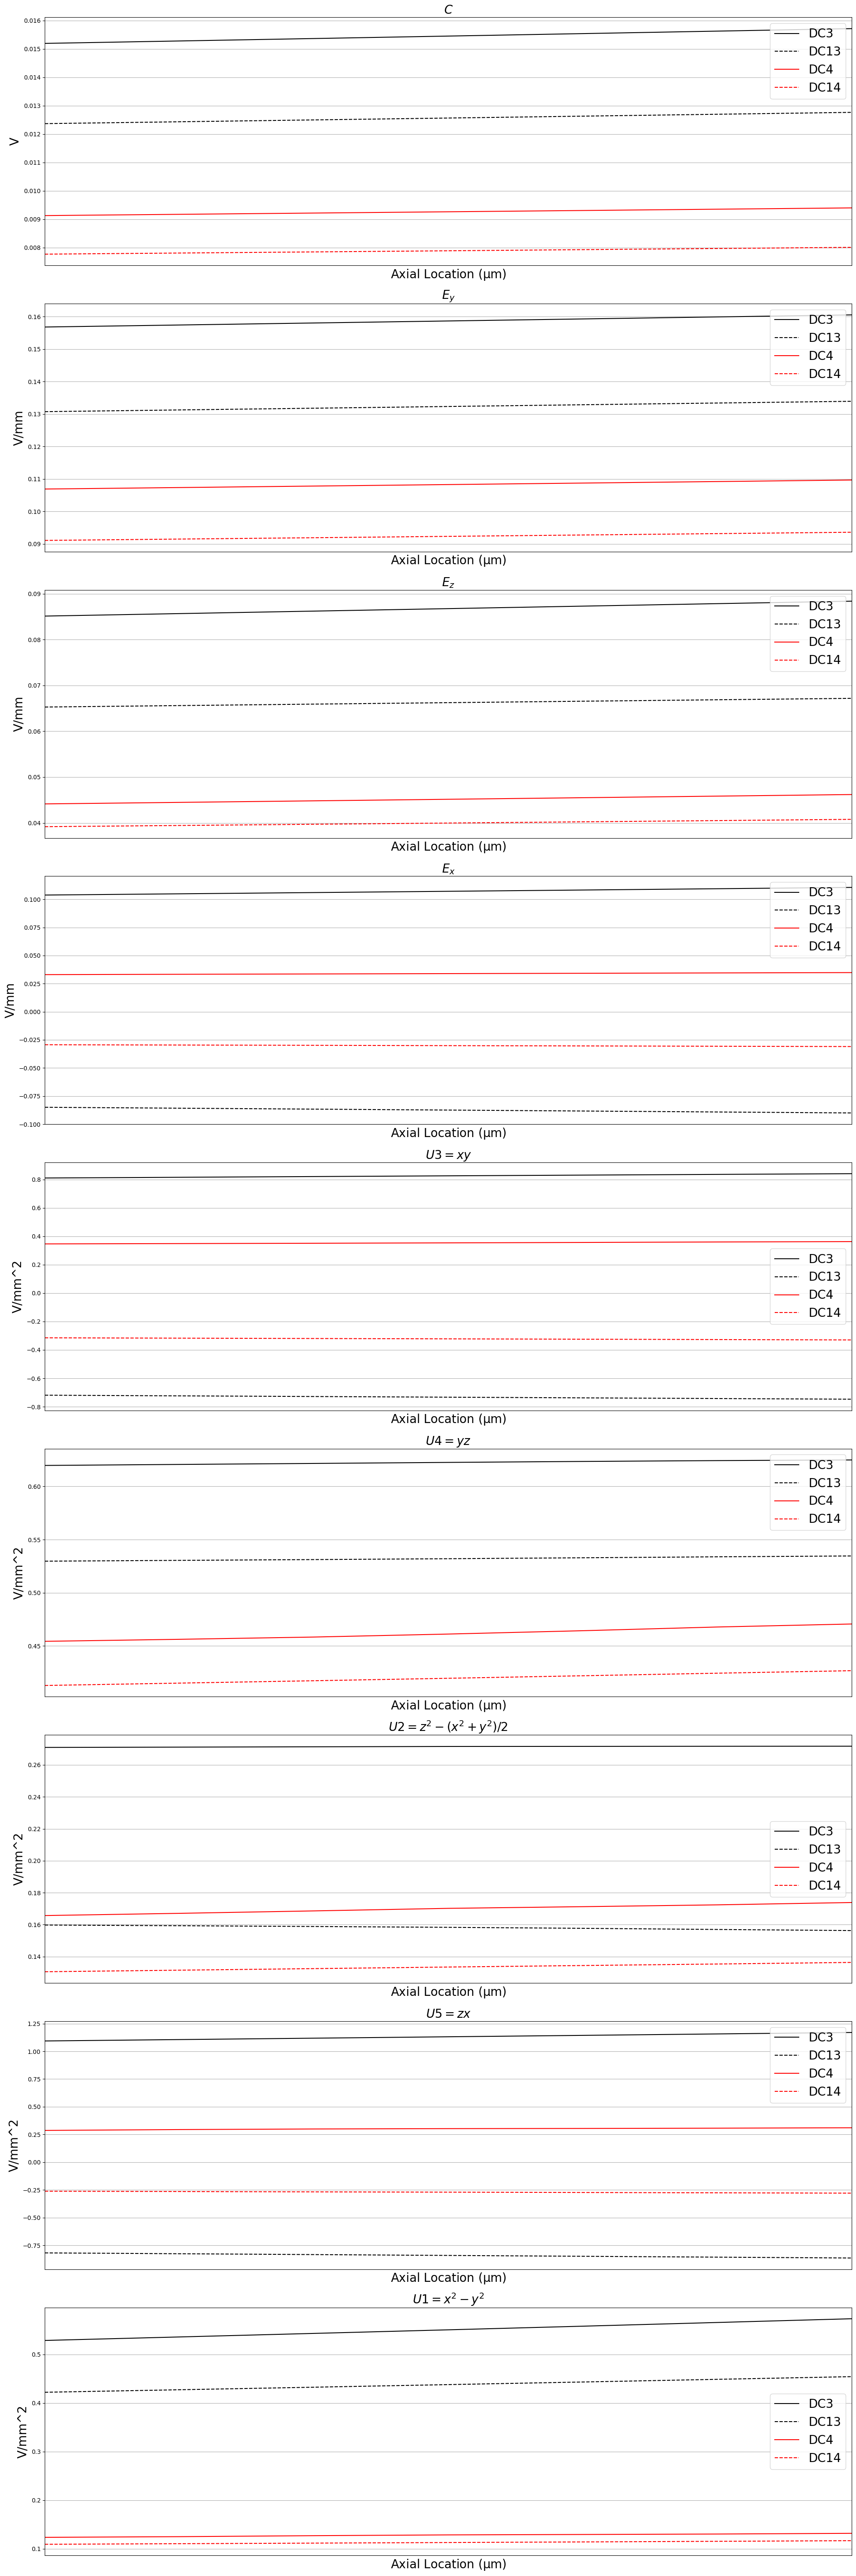

In [8]:
# 'height_list' is the list of the places to do the spherical decomp. of the electrode potential
# 'height_list' currently refers to axial locations
height_list = trap['Z'][2:len(trap['Z'])-2]
numMUltipoles = len(s.multipole_print_names)


ne = len(s.electrode_names)
multipoles_vs_height = np.zeros((len(height_list), numMUltipoles, ne))

for i, height in enumerate(height_list):
    position1 = [xl, yl,height]
    s.update_origin_roi(position1, roi)
    multipoles_vs_height[i] = np.asarray(s.multipole_expansion.loc[s.multipole_names])

size = 20
electrode_list = ['DC3','DC13','DC4','DC14']

fig, ax = plt.subplots(numMUltipoles, 1, figsize=(20, 60))
for i, mul in enumerate(s.multipole_print_names):
    ax[i].set_prop_cycle(linestyle = ['-','--','-','--','-','--','--','--','--','--'],color= ['black','black','red','red','orange','black','blue','purple','red','orange'])
    for ele in electrode_list:
        j = s.electrode_names.index(ele)
        ax[i].plot(height_list*1e3, multipoles_vs_height[:, i, j], label=ele)
        if i == 0:
            ax[i].set_ylabel('V',fontsize=size)
        elif i < 4:
            ax[i].set_ylabel('V/mm',fontsize=size)
        else:
            ax[i].set_ylabel('V/mm^2',fontsize=size)
        ax[i].set_title(mul, fontsize=size)
        ax[i].set_xticks(np.arange(-300,300,1))
        ax[i].set_xlabel(r'Axial Location ($\mathrm{\mu}$m)', fontsize=size)
        ax[i].set_xlim(min(height_list*1e3),max(height_list*1e3))
        ax[i].grid(visible=True)
        ax[i].legend(fontsize=size)
    fig.tight_layout()

## Generating Axial Confinment
Here are plots of the voltage solutions that generate axial confinement. We generate axial confinement by generating a DC field 
that corresponds to a specific 2nd order multipole. The 

multipole_coeffs:  {'Ex': 0.0, 'Ey': 0.0, 'Ez': 0.0, 'U1': 0, 'U2': 5, 'U3': 0, 'U4': 0, 'U5': 0}
['DC1', 'DC2', 'DC3', 'DC4', 'DC5', 'DC6', 'DC7', 'DC8', 'DC9', 'DC10', 'DC11', 'DC12', 'DC13', 'DC14', 'DC15', 'DC16', 'DC17', 'DC18', 'DC19', 'DC20', 'DC21']
voltages: 
{'DC1': 0.2292566502972158, 'DC2': -2.960284185872349, 'DC3': 1.094544284420692, 'DC4': 0.014542889499949703, 'DC5': -0.359449387008808, 'DC6': -0.26655850719193414, 'DC7': -0.21816931930998346, 'DC8': -0.18221035637457483, 'DC9': -0.14788123965893607, 'DC10': -0.12589380707814601, 'DC11': -1.1477568048298261, 'DC12': -2.970976348462304, 'DC13': -0.7189444944524658, 'DC14': -0.6309807283525806, 'DC15': -0.3974074095049952, 'DC16': -0.22942787993775665, 'DC17': -0.17379802844269748, 'DC18': -0.13465013022250785, 'DC19': -0.10607018082906389, 'DC20': -0.08778866200045296, 'DC21': -0.5985957259431134}
type:  <class 'dict'>

Remapped voltages: 
{'DC21': 0.2292566502972158, 'DC20': -2.960284185872349, 'DC19': 1.094544284420692

C:\Users\Photonics\AppData\Local\Temp\ipykernel_7520\3833127207.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(s.controlled_elecs, rotation=45, fontsize=12)


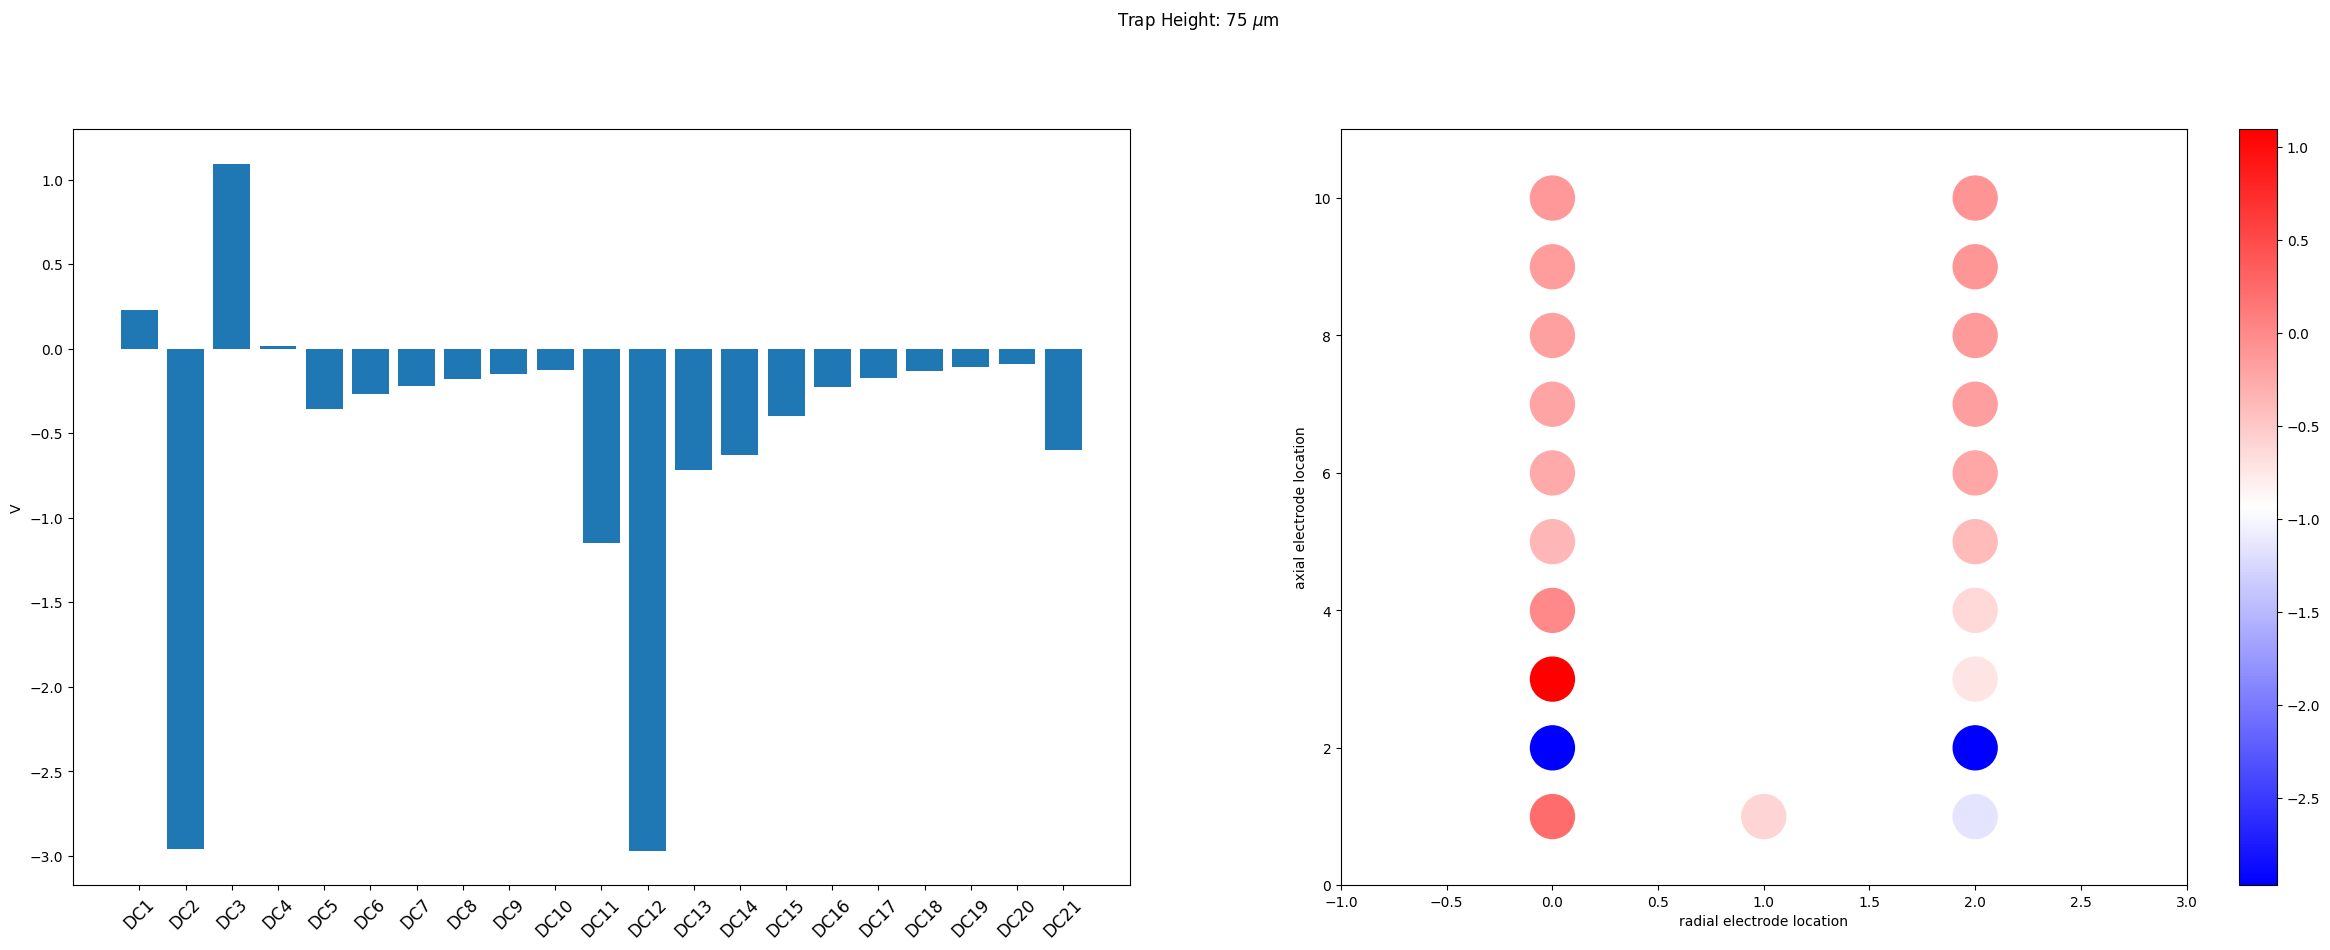

<Figure size 640x480 with 0 Axes>

In [19]:
def plot_muls(s,xl,zl,roi,height, **multipoles): # ey, ez, ex, u3, u2, u5, u1, u4):
    position1 = [xl, height * 1e-3, zl]
    s.update_origin_roi(position1, roi)
    multipole_coeffs = {key:multipoles[key.lower()] for key in s.used_multipoles}
    print("multipole_coeffs: ", multipole_coeffs)
        
    #multipole_coeffs = {'Ey': ey, 'Ez': ez, 'Ex': ex, 'U3': u3, 'U2': u2, 'U5': u5, 'U1': u1,'U4':u4}
    voltages = s.setMultipoles(multipole_coeffs)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 12))
    fig.suptitle(f'Trap Height: {height:0.0f} $\mu$m')
    ax1.bar(s.controlled_elecs, voltages)
    ax1.set_xticklabels(s.controlled_elecs, rotation=45, fontsize=12)
    #     ax1.set_ylim(-25, 40)
    ax1.set_ylabel('V')
    print(s.controlled_elecs)
    xpos = [s.electrode_positions[ele][0] for ele in s.controlled_elecs]
    ypos = [s.electrode_positions[ele][1] for ele in s.controlled_elecs]
    plot = ax2.scatter(xpos, ypos, 1000, list(voltages), cmap='bwr')
    fig.colorbar(plot)
    ax2.set_ylabel("axial electrode location")
    ax2.set_xlabel("radial electrode location")
    ax2.set_xlim(min(xpos) - 1, max(xpos) + 1)
    ax2.set_ylim(min(ypos) - 1, max(ypos) + 1)
    plt.subplots_adjust(bottom=0.25)
    # plt.show()

    # Convert voltages into a dictionary with electrode names as keys
    voltages_dict = dict(zip(s.controlled_elecs, voltages))
    return voltages_dict

voltages = plot_muls(s,xl,zl,roi,
                     height = yl*1e3,
                     ez=0.0,
                     ex=0.0,
                     ey=0.0,
                     u2=5,
                     u5=0,
                     u1=0,
                     u3=0,
                     u4=0)
print(f"voltages: \n{voltages}")
print("type: ", type(voltages))

voltage_mapping = {
    "DC1": "DC21",
    "DC2": "DC20",
    "DC3": "DC19",
    "DC4": "DC18",
    "DC5": "DC17",
    "DC6": "DC16",
    "DC7": "DC15",
    "DC8": "DC14",
    "DC9": "DC13",
    "DC10": "DC12",
    "DC11": "DC10",
    "DC12": "DC9",
    "DC13": "DC8",
    "DC14": "DC7",
    "DC15": "DC6",
    "DC16": "DC5",
    "DC17": "DC4",
    "DC18": "DC3",
    "DC19": "DC2",
    "DC20": "DC1",
    "DC21": "DC11",
}

# Remap the voltages dictionary keys using voltage_mapping
remapped_voltages = {voltage_mapping.get(k, k): v for k, v in voltages.items()}
print(f"\nRemapped voltages: \n{remapped_voltages}")

fig.canvas.draw()
fig.tight_layout(pad=1)
fig = plt.figure()
plt.show()

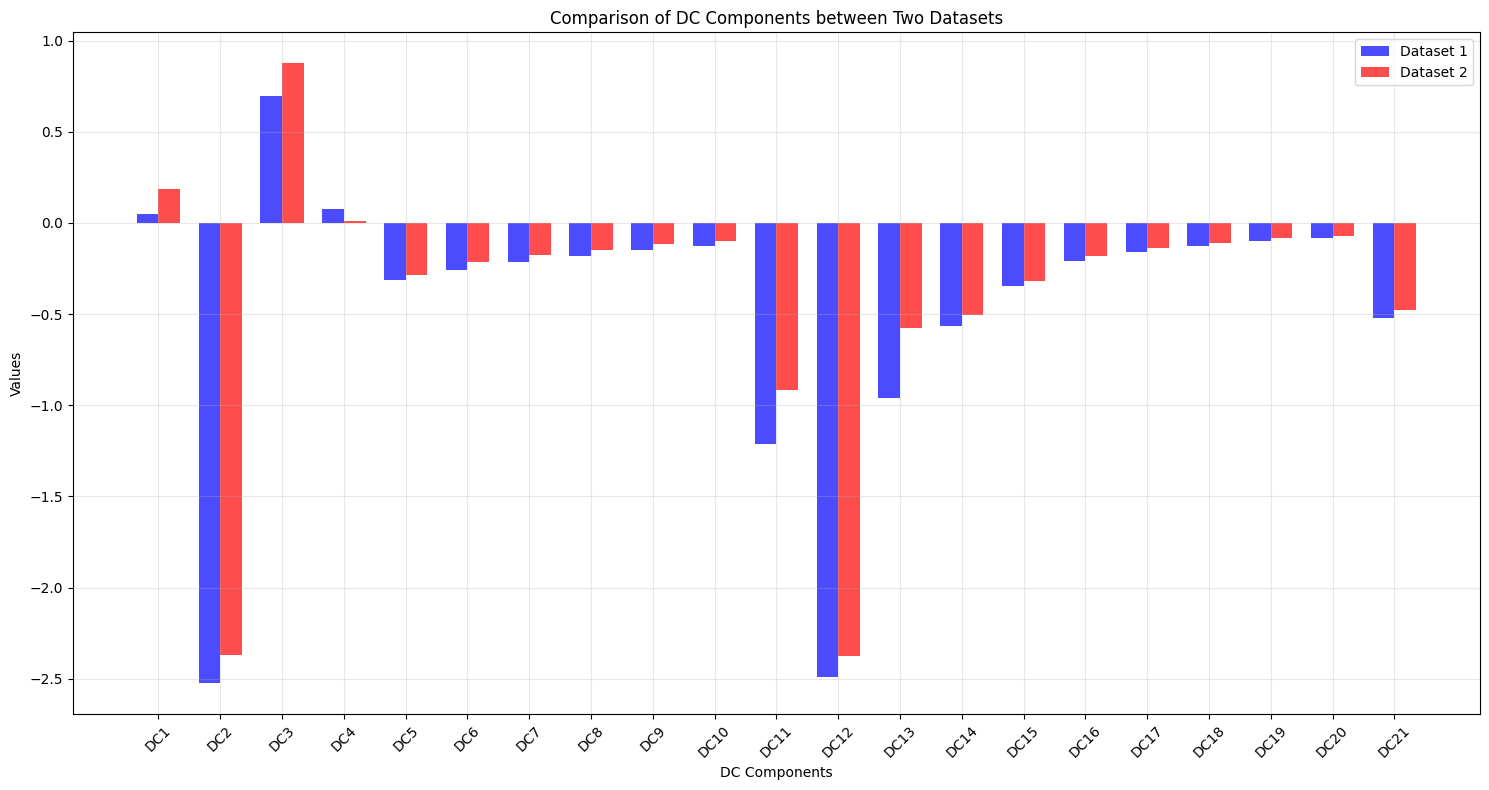

In [10]:
import matplotlib.pyplot as plt
import json

# Data
data1 = {'DC1': 0.049851917056472794, 'DC2': -2.522675629892661, 'DC3': 0.6959012558081819, 'DC4': 0.07758433335111928, 'DC5': -0.31564964310206645, 'DC6': -0.25741305312456564, 'DC7': -0.21395120489510905, 'DC8': -0.18008597523386644, 'DC9': -0.146532897146409, 'DC10': -0.12487576097633207, 'DC11': -1.2108464439929536, 'DC12': -2.4886469367505564, 'DC13': -0.9594514274413023, 'DC14': -0.5679240789247384, 'DC15': -0.34756641744517824, 'DC16': -0.21002560665005454, 'DC17': -0.1617091125344762, 'DC18': -0.126422949361739, 'DC19': -0.10063512963461281, 'DC20': -0.08422501524726243, 'DC21': -0.5217536387347478}

data2 = {'DC1': 0.18340532023777265, 'DC2': -2.3682273486978795, 'DC3': 0.8756354275365537, 'DC4': 0.011634311599959762, 'DC5': -0.2875595096070464, 'DC6': -0.2132468057535473, 'DC7': -0.17453545544798676, 'DC8': -0.14576828509965986, 'DC9': -0.11830499172714887, 'DC10': -0.10071504566251681, 'DC11': -0.9182054438638609, 'DC12': -2.3767810787698433, 'DC13': -0.5751555955619726, 'DC14': -0.5047845826820645, 'DC15': -0.3179259276039962, 'DC16': -0.18354230395020532, 'DC17': -0.13903842275415798, 'DC18': -0.10772010417800627, 'DC19': -0.08485614466325112, 'DC20': -0.07023092960036237, 'DC21': -0.47887658075449074}

# Create figure and axis
plt.figure(figsize=(15, 8))

# Get x-axis positions
x = range(len(data1))

# Create bars
width = 0.35
plt.bar([i - width/2 for i in x], data1.values(), width, label='Dataset 1', color='blue', alpha=0.7)
plt.bar([i + width/2 for i in x], data2.values(), width, label='Dataset 2', color='red', alpha=0.7)

# Customize the plot
plt.xlabel('DC Components')
plt.ylabel('Values')
plt.title('Comparison of DC Components between Two Datasets')
plt.xticks(x, [f'DC{i+1}' for i in x], rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show plot
plt.show()

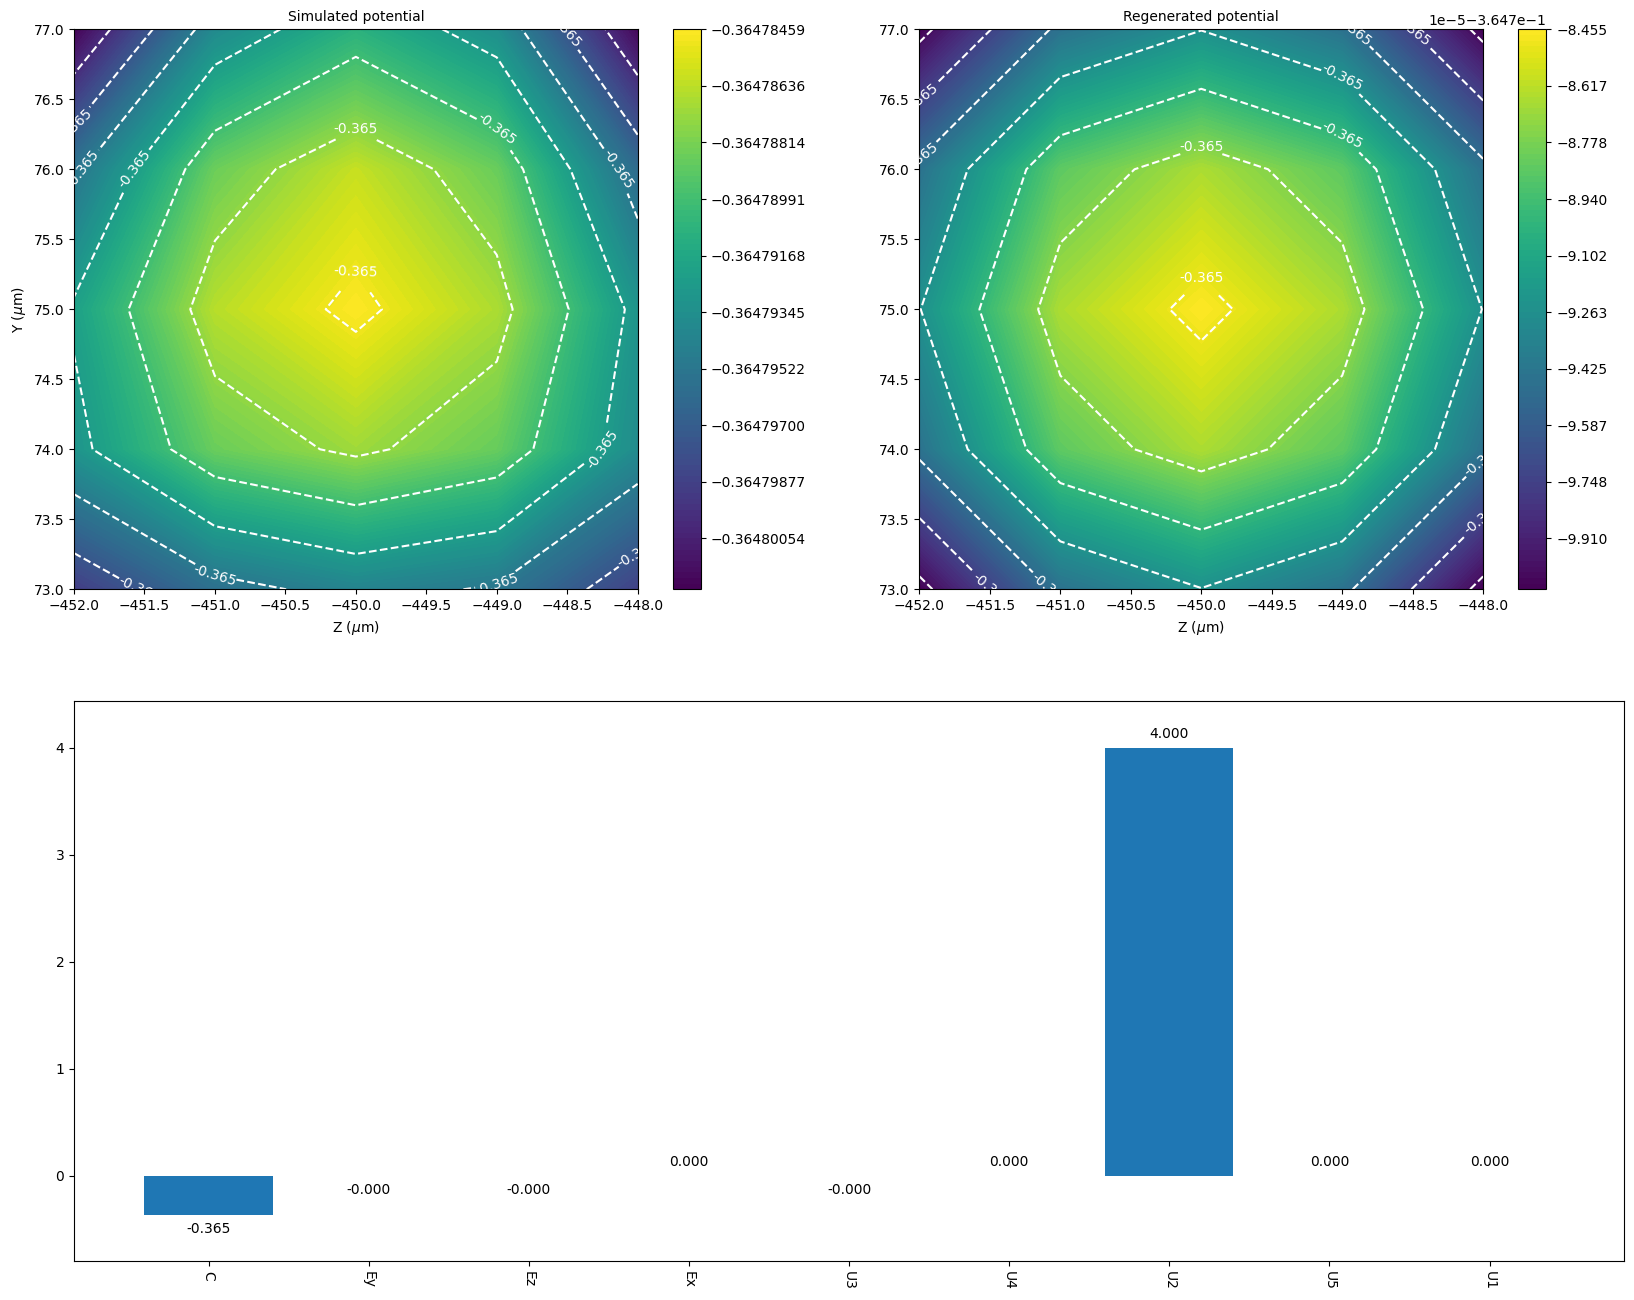

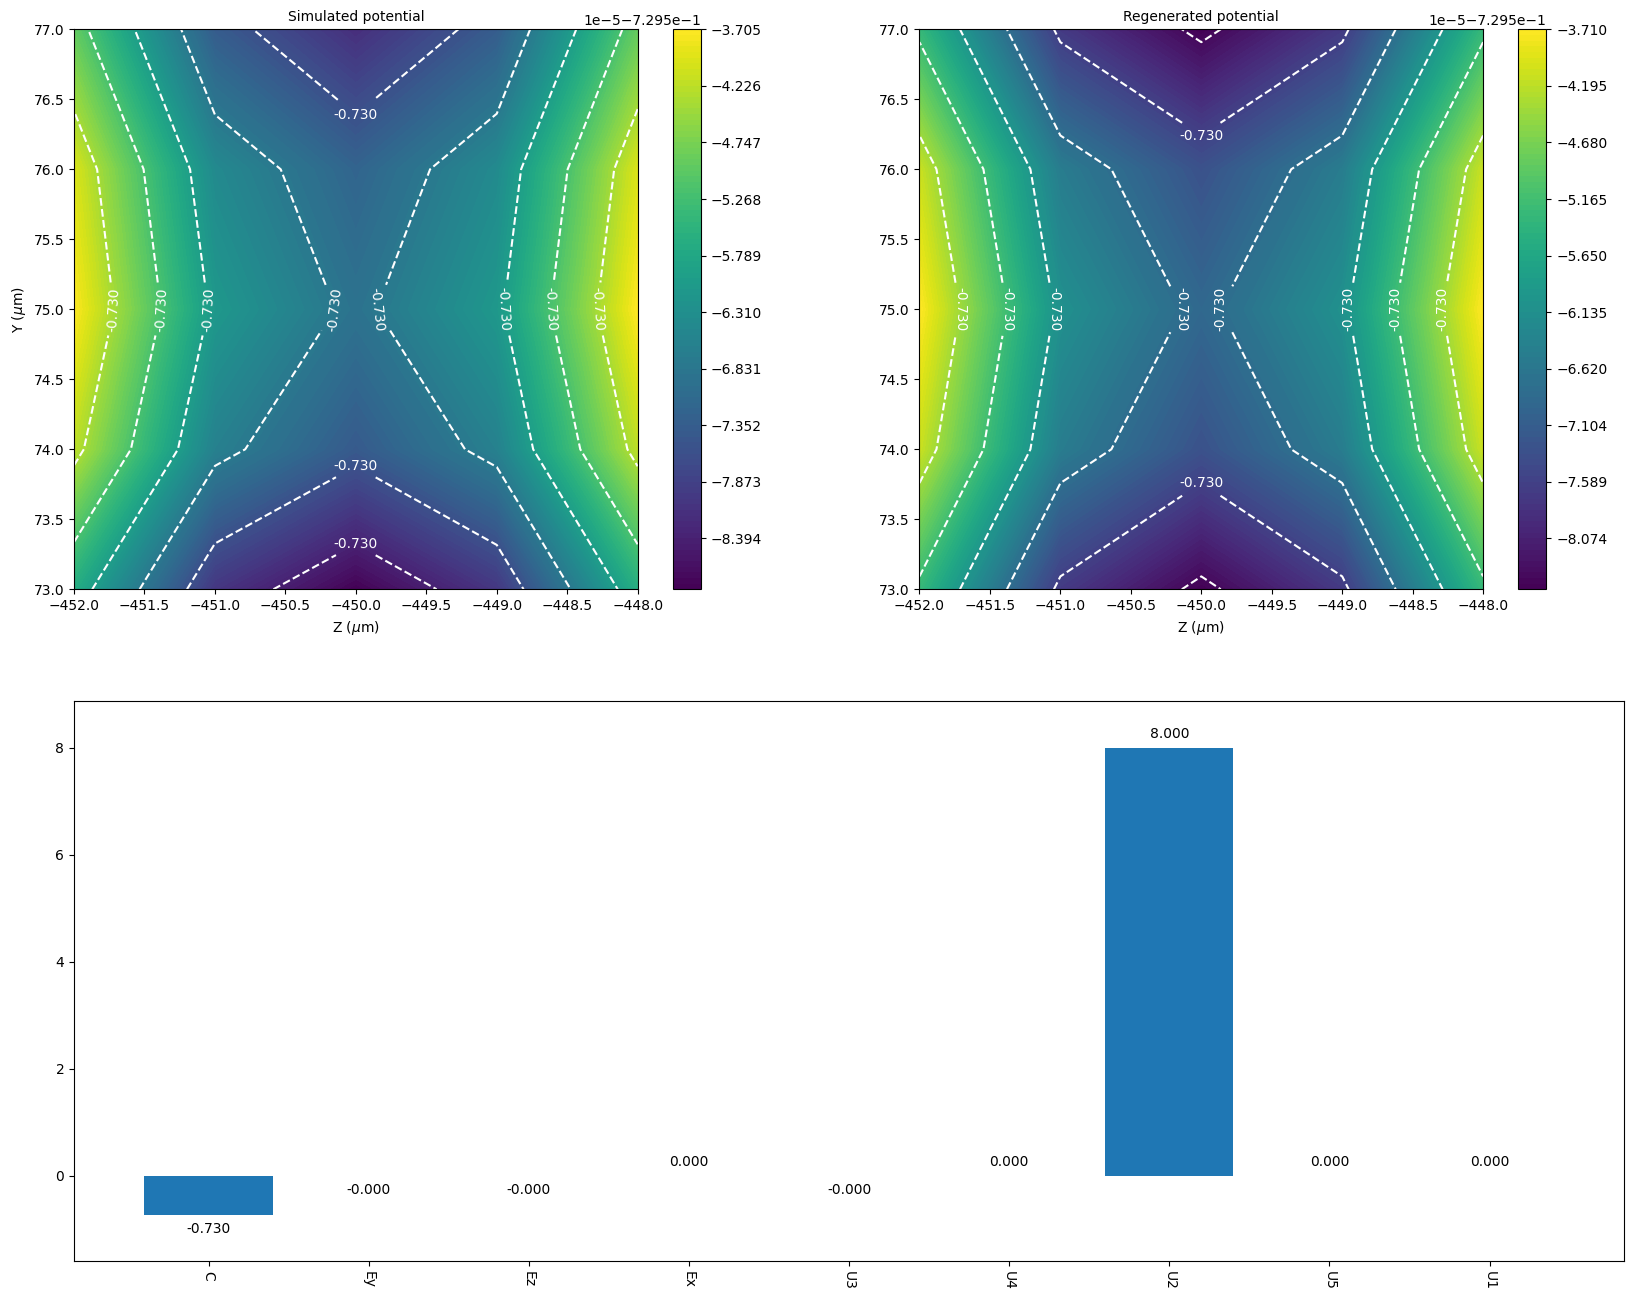

In [11]:
import matplotlib as mpl
mpl.rc('xtick', labelsize=10) 
mpl.rc('ytick', labelsize=10) 
u4 = 0
# plot_U2(s,xl,zl,roi,height=50.00, ez=0, ex=0, ey=0, u2=10, u5=0, u1=0, u3=0)
def plot_U21(s,xl,zl,roi,height, ey, ez, ex, u3, u2, u5, u1,view='zy'):
    position1 = [xl, height * 1e-3, zl]
    s.update_origin_roi(position1, roi)
    multipole_coeffs = {'Ey': ey, 'Ez': ez, 'Ex': ex
    , 'U3': u3, 'U2': u2, 'U5': u5, 'U1': u1,'U4':u4}
    voltages = s.setMultipoles(multipole_coeffs)
    potential_roi = s.potentialControl_roi(voltages)
    potential_regen = s.potentialControl_regen(voltages)
    # nearestZ = find_nearest(s.Z, height * 1e-3)
    # indNearestZ_roi = np.abs(s.Z_roi - nearestZ).argmin()
    fsize = 10
    fig1 = plt.figure(figsize=(20, 16))
    if view == 'zy':
        nearestX = find_nearest(s.X, xl)
        indNearestX_roi = np.abs(s.X_roi - nearestX).argmin()
        potential_xy_roi = potential_roi[indNearestX_roi]
        potential_xy_regen = potential_regen[indNearestX_roi]
        fig.suptitle('Z-Y Plane',fontsize=20)
    else:
        nearestZ = find_nearest(s.Z, zl)
        indNearestZ_roi = np.abs(s.Z_roi - nearestZ).argmin()
        potential_xy_roi = potential_roi[:,:,indNearestZ_roi]
        potential_xy_regen = potential_regen[:,:,indNearestZ_roi]
        potential_xy_regen = np.transpose(potential_xy_regen)
        potential_xy_roi = np.transpose(potential_xy_roi)
        fig.suptitle('X-Y Plane',fontsize=20)
    grid = plt.GridSpec(2, 2)
    ax1 = fig1.add_subplot(grid[0, 0])
    ax2 = fig1.add_subplot(grid[0, 1])
    ax3 = fig1.add_subplot(grid[1, :])
    ax1.set_title('Simulated potential', fontsize=fsize)
    levels1 = np.linspace(np.amin(potential_xy_roi), np.amax(potential_xy_roi), 100)
    plot1 = ax1.contourf(s.Z_roi * 1e3, s.Y_roi * 1e3, potential_xy_roi, levels1, cmap=plt.cm.viridis)
    plot1_line = ax1.contour(s.Z_roi * 1e3, s.Y_roi * 1e3, potential_xy_roi, colors='w')
    #     ax1.clabel(plot1_line, inline = 1, fontsize = fsize)
    ax1.clabel(plot1_line, colors='w', fmt='%2.3f', fontsize=fsize)
    ax1.set_xlabel('Z ($\mu$m)', fontsize=fsize)
    ax1.set_ylabel('Y ($\mu$m)', fontsize=fsize)
    plt.colorbar(plot1, ax=ax1)

    ax2.set_title('Regenerated potential', fontsize=fsize)
    levels2 = np.linspace(np.amin(potential_xy_regen), np.amax(potential_xy_regen), 100)
    plot2 = ax2.contourf(s.Z_roi * 1e3, s.Y_roi * 1e3, potential_xy_regen, levels2, cmap=plt.cm.viridis)
    plot2_line = ax2.contour(s.Z_roi * 1e3, s.Y_roi * 1e3, potential_xy_regen, colors='w')
    #     ax2.clabel(plot2, inline = 1, fontsize = fsize)
    ax2.clabel(plot2_line, colors='w', fmt='%2.3f', fontsize=fsize)
    ax2.set_xlabel('Z ($\mu$m)', fontsize=fsize)
    plt.colorbar(plot2, ax=ax2)
    coeffs = s.setVoltages(voltages)
    ax3.bar(np.arange(9), np.asarray(coeffs)[0:9])
    max_coeff = np.max(coeffs[0:9])
    min_coeff = np.min(coeffs[0:9])
    margin = (max_coeff - min_coeff) * 0.1
    ymax = max_coeff + margin
    ymin = min_coeff - margin
    ax3.set_ylim(ymin, ymax)
    add_value_labels(ax3)
    ax3.set_xticks(np.arange(9))
    ax3.set_xticklabels(s.multipole_names, rotation=-90, fontsize=fsize)
    plt.show()
plot_U21(s,xl,zl,roi,height=yl*1e3, ez=0, ex=0, ey=0, u2=4, u5=0, u1=0, u3=0,view = 'xy')
plot_U21(s,xl,zl,roi,height=yl*1e3, ez=0, ex=0, ey=0, u2=8, u5=0, u1=0, u3=0,view = 'zy')